In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

### Data import

In [2]:
dataset_name = "SAS_3"
current_path = os.getcwd()  # Get current working directory
parent_path = os.path.dirname(current_path)
data_dir = parent_path + "/dataset/" + dataset_name
data = pd.read_sas(data_dir + '/aeendpt.sas7bdat', format="sas7bdat")
keep_columns = ['PFSDYLRE', 'PFSLRE', 'DTHDY', 'DTH', 'ATRT', 'SEX', 'AGE', 'RACE', 'PRHNTRTC', 'CARBOADD', 'CARBO2D', 'B_ECOG', 'DIAGTYPE']
data = data[keep_columns]
data = data[data['PFSDYLRE'] <= data['DTHDY']]
data = data.drop(['PFSDYLRE', 'PFSLRE'] , axis=1)
keep_columns = data.columns.values

In [3]:
data.shape

(520, 11)

### Data preprocessing

In [4]:
# Handle missing data
for col in keep_columns:
    if col not in ['DTHDY', 'DTH', 'ATRT']:
        if len(data[col].unique()) > 20:
            data[col].fillna(data[col].mean(), inplace=True)
        else:
            data[col].fillna(data[col].mode()[0], inplace=True)
data = data[keep_columns].dropna()

In [5]:
data.shape

(520, 11)

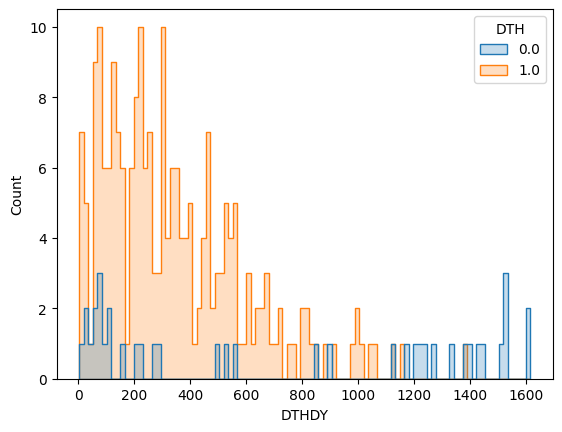

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(data=data[data["ATRT"] == b'panit. plus chemotherapy'] , x="DTHDY", hue="DTH", bins=100, element="step", stat="count", common_bins=True)
plt.show()

In [7]:
# Encode the features
for col in keep_columns:
    if col not in ['DTHDY', 'DTH', 'ATRT']:
    # if col not in ["overall_survival_months", "overall_survival", "chemotherapy", "age_at_diagnosis"]:
        unique_value = np.unique(data[col].values)

        # Create a mapping dictionary
        mapping = dict(zip(unique_value, np.arange(len(unique_value))))

        # Replace values in the column
        data[col] = data[col].replace(mapping)

### Data types

In [8]:
data_types = [["name", "type", "dim", "nclass"], ["survcens", "surv_piecewise", 2, np.nan]]
for col in keep_columns:
    if col not in ['DTHDY', 'DTH', 'ATRT']:
        n_unique = len(np.unique(data[col].values))
        if n_unique < 20:
            data_types.append([col, "cat", 1, n_unique])
        else:
            if (data[col] > 0).all():
                data_types.append([col, "pos", 1, np.nan])
            else:
                data_types.append([col, "real", 1, np.nan])

In [9]:
data_types

[['name', 'type', 'dim', 'nclass'],
 ['survcens', 'surv_piecewise', 2, nan],
 ['SEX', 'cat', 1, 2],
 ['AGE', 'real', 1, nan],
 ['RACE', 'cat', 1, 5],
 ['PRHNTRTC', 'cat', 1, 2],
 ['CARBOADD', 'cat', 1, 1],
 ['CARBO2D', 'cat', 1, 1],
 ['B_ECOG', 'cat', 1, 3],
 ['DIAGTYPE', 'cat', 1, 4]]

### Split data into treated and control group

In [10]:
np.unique(data["ATRT"].values)

array([b'Chemotherapy', b'panit. plus chemotherapy'], dtype=object)

In [11]:
data = data.rename(columns={"DTHDY": "time", "DTH": "censor"})
data_treated = data[data['ATRT']==b'Chemotherapy'].drop(['ATRT'] , axis=1)
data_control = data[data['ATRT']==b'panit. plus chemotherapy'].drop(['ATRT'] , axis=1)

In [12]:
data_control.shape

(260, 10)

### Save data

In [13]:
import csv

data.to_csv(data_dir + "/data.csv", header=False, index=False)
data_treated.to_csv(data_dir + "/data_treated.csv", header=False, index=False)
data_control.to_csv(data_dir + "/data_control.csv", header=False, index=False)
pd.DataFrame(data_types).to_csv(data_dir + "/data_types_treated.csv", index=False, header=False)
pd.DataFrame(data_types).to_csv(data_dir + "/data_types_control.csv", index=False, header=False)